### Fx Rate Forecasting for Japanese Yen

In [1]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'notebook_connected'
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
import warnings
import statsmodels.api as sm
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
import arch
from arch import arch_model
warnings.simplefilter(action='ignore', category=FutureWarning)
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("Data/yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 ### Return Forecasting: Initial Time-Series Plotting

In [2]:
# Plot just the "Settle" column from the dataframe:
px.line(yen_futures['Settle'],title='Yen-Futures Settlement Price')

---

### Decomposition Using a Hodrick-Prescott Filter

<AxesSubplot:title={'center':'Settle PRICE since 2015'}, xlabel='Settle', ylabel='Settle_trend'>

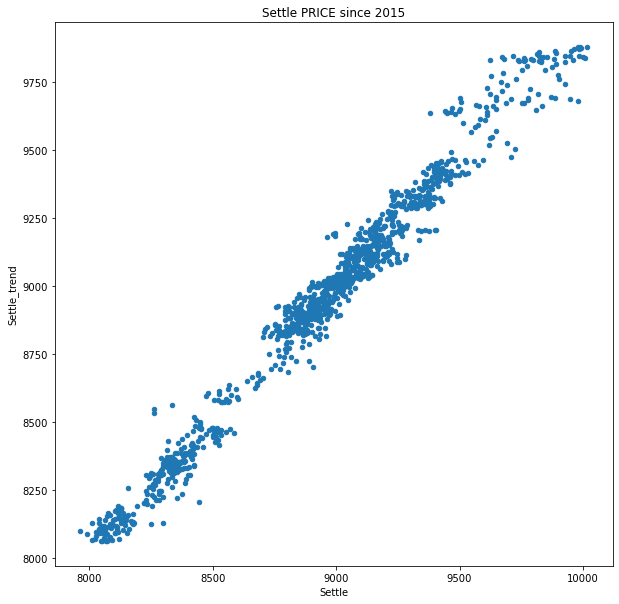

In [3]:
# Split settle price between Trend & Noise
settle_noise, settle_trend = sm.tsa.filters.hpfilter(yen_futures["Settle"])
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
decomposition = pd.concat([yen_futures["Settle"],settle_noise,settle_trend], axis='columns', join='inner')
decomposition.dropna(inplace=True)
# Plot the Settle Price vs. the Trend for 2015 to the present
decomposition.loc['2015-01-01':].plot(kind='scatter', x='Settle', y='Settle_trend', figsize=(10,10), title='Settle PRICE since 2015')

In [4]:
# Plot the Settle Price vs. the Trend for 2015 to the present

fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_trace(
    go.Scatter(x=decomposition['2015-01-01':].index, y=decomposition['Settle'], name="Settle"),
    row=1, col=1, secondary_y=False)

fig.add_trace(
    go.Scatter(x=decomposition['2015-01-01':].index, y=decomposition['Settle_trend'], name="Settle_trend"),
    row=1, col=1, secondary_y=True,
)
fig.show()

In [5]:
# Plot the Settle Price vs. the Trend for 2015 to the present
px.scatter(decomposition.loc['2015-01-01':], x="Settle", y="Settle_trend", title='Settle PRICE (using HVPLOT) since 2015')

In [6]:
# Plot the Settle Noise
px.line(decomposition, x=decomposition.index, y=decomposition['Settle'],title='Settle NOISE (using HVPLOT) since 2015')

---

# Forecasting Returns using an ARMA Model

### Using futures Settle *Returns*, estimate an ARMA model

In [7]:
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
model = ARMA(returns.values, order=(2,1))
result = model.fit()
print(result.summary())
# Plot the 5 Day Returns Forecast
px.line(result.forecast(steps=5)[0],title='Five Day ARMA')

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Sun, 06 Feb 2022   AIC                          15798.142
Time:                        19:56:47   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.804      0.421      -0.009       0.022
ar.L1.y       -0.3063      1.277     -0.240      0.810      -2.810       2.197
ar.L2.y       -0.0019      0.019     -0.099      0.9

---

### Forecasting the Settle Price using an ARIMA Model

In [8]:
arima = ARIMA(returns.values, order=(5,1,1))
# Fit the model
arima_results = arima.fit()
# Output model summary results:
print(arima_results.summary())
# Plot the 5 Day Price Forecast
px.line(arima_results.forecast(steps=5)[0],title='Five Day ARIMA')

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 7513
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -7895.748
Method:                       css-mle   S.D. of innovations              0.692
Date:                Sun, 06 Feb 2022   AIC                          15807.497
Time:                        19:56:59   BIC                          15862.892
Sample:                             1   HQIC                         15826.517
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.216e-06   3.55e-06     -0.905      0.365   -1.02e-05    3.75e-06
ar.L1.D.y     -0.0134      0.012     -1.159      0.246      -0.036       0.009
ar.L2.D.y     -0.0021      0.012     -0.184      0.8

---

### Volatility Forecasting with GARCH

Forecasting near-term **volatility** of Japanese Yen futures returns. 

In [9]:
garch = arch_model(returns, mean='Zero', vol='GARCH', p=2, q=1)
garch_results = garch.fit(disp='off')
garch_results.summary()
last_day = returns.index.max().strftime('%Y-%m-%d')
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecast = garch_results.forecast(start=last_day, horizon=forecast_horizon)
# Annualizing
intermediate = np.sqrt(forecast.variance.dropna() * 252)
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
# Plot the final forecast
px.line(final,title='Five Day VOLATILITY')

---

# Conclusions

The ARIMA model suggests a futher decline in the prices over the predicted period.
However, the models have a significantly higher p-value, indicating the results are not reliable.
There is not enough information to determine whether buying the yen right now is a good decision.